In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import model_HIVandSTI
from tapm import utils
import icomo
import diffrax
import numpy as np

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
#output = integrator(y0=y0, constant_args=args)
output = icomo.diffeqsolve(
    args = model_HIVandSTI.args,
    ODE = model_HIVandSTI.main_model,
    y0 = model_HIVandSTI.y0,
    ts_out = np.linspace(0, 365*20, 365*20+1),
    max_steps=365*20+1)

INFO:tapm.HIVandSTI.model_HIVandSTI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.model_HIVandSTI:Parameters: min_exp = 0.0, max_exp = 1.0, tau_exp = 0.2


In [4]:
def n_observed(args, y):
    out = args["lambda_s"]*jnp.sum(jnp.array([y["Is1_STI"], y["Is2_STI"], y["Is3_STI"], y["Is4_STI"]]))+model_HIVandSTI.lambda_a(args=args, y=y)*jnp.sum(jnp.array([y["Ia1_STI"], y["Ia2_STI"], y["Ia3_STI"], y["Ia4_STI"]]))
    return out

KeyError: 'Is1_STI'

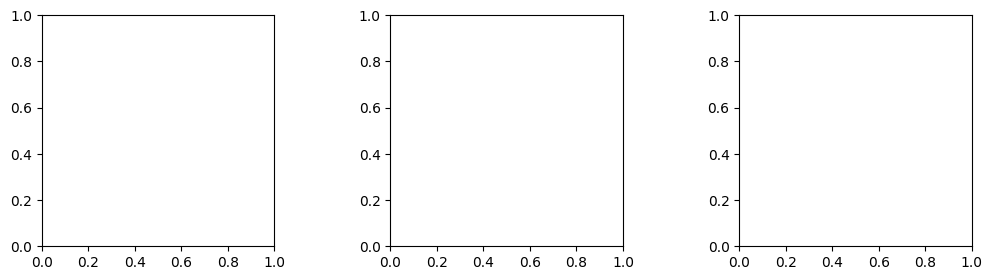

In [5]:

fig, axes = plt.subplots(1, 3, figsize=(12,3))
fig.subplots_adjust(wspace=0.5)

# STI
ax = axes[0]
ax.plot(output.ys["Is1_STI"]+output.ys["Ia1_STI"], label="Infected- STI - RG 1")
ax.plot(output.ys["Is2_STI"]+output.ys["Ia2_STI"] , label="Infected- STI - RG 2")
ax.plot(output.ys["Is3_STI"]+output.ys["Ia3_STI"], label="Infected- STI - RG 3")
ax.plot(output.ys["Is4_STI"]+output.ys["Ia4_STI"], label="Infected- STI - RG 4")
ax.set_ylabel("Number of people")
ax.set_xlabel("Time")
ax.set_title("STI")
ax.legend()
print("STI done")

# HIV
ax = axes[1]
ax.plot(output.ys["A11"]+output.ys["A12"]+output.ys["A13"]+output.ys["A14"], label="ART - RG 1", color="blue")
ax.plot(output.ys["A21"]+output.ys["A22"]+output.ys["A23"]+output.ys["A24"], label="ART - RG", color="steelblue")
ax.plot(output.ys["A31"]+output.ys["A32"]+output.ys["A33"]+output.ys["A34"], label="ART - RG 3", color="lightblue")
ax.plot(output.ys["A41"]+output.ys["A42"]+output.ys["A43"]+output.ys["A44"], label="ART - RG 4", color="navy")
# I per risk group in different shades of red
ax.plot(output.ys["I11"]+output.ys["IP11"]+output.ys["I12"]+output.ys["I13"]+output.ys["I14"], label="Infected - RG 1", color="red")
ax.plot(output.ys["I21"]+output.ys["IP21"]+output.ys["I22"]+output.ys["I23"]+output.ys["I24"], label="Infected - RG 2", color="darkred")
ax.plot(output.ys["I31"]+output.ys["IP31"]+output.ys["I32"]+output.ys["I33"]+output.ys["I34"], label="Infected - RG 3", color="lightcoral")
ax.plot(output.ys["I41"]+output.ys["IP41"]+output.ys["I42"]+output.ys["I43"]+output.ys["I44"], label="Infected - RG 4", color="hotpink")
ax.set_ylabel("Number of people")
ax.set_xlabel("Time")
ax.set_title("HIV")
ax.legend()
print("HIV done")

# hazard
ax = axes[2]
all_HIV_keys = ["S1","S2","S3","S4","SP1","SP2","SP3","SP4","I11","I21","I31","I41","IP11","IP21","IP31","IP41","I12","I22","I32","I42","I13","I23","I33","I43","I14","I24","I34","I44","A11","A21","A31","A41","A12","A22","A32","A42","A13","A23","A33","A43","A14","A24","A34","A44"]
all_ART_keys = ["A11","A12","A13","A14","A21","A22","A23","A24","A31","A32","A33","A34","A41","A42","A43","A44"]
sum_vector = np.sum(np.array([output.ys[k] for k in all_HIV_keys]), axis=0) # gives the sum of all HIV compartments for each time point
#for i in range(len(output.ys["A11"])):
#    compartment_values = jnp.array([output.ys[key][i] for key in all_ART_keys])
#    hazard = jnp.sum(compartment_values) / sum_vector[i] *100
#    ax.scatter(i, hazard, color="black", s=1)
compartment_matrix = np.array([output.ys[key] for key in all_ART_keys])  # Shape: (len(all_ART_keys), time_points)
hazard_vector = jnp.sum(compartment_matrix, axis=0) / sum_vector * 100   # Vectorized hazard computation

# Plot all points at once
ax.scatter(range(len(hazard_vector)), hazard_vector, color="black", s=1)
ax.set_ylabel("Hazard (%)")
ax.set_xlabel("Time")

In [ ]:

#plt.plot(output.ys["S1_STI"]+output.ys["S2_STI"]+output.ys["S3_STI"]+output.ys["S4_STI"], label="Susceptible - STI")
#plt.plot(output.ys["Is1_STI"]+output.ys["Is2_STI"]+output.ys["Is3_STI"]+output.ys["Is4_STI"], label="Infected(Symptomatic) - STI")
#plt.plot(output.ys["Ia1_STI"]+output.ys["Ia2_STI"]+output.ys["Ia3_STI"]+output.ys["Ia4_STI"], label="Infected(Asymptomatic) - STI")
#plt.plot(output.ys["T1_STI"]+output.ys["T2_STI"]+output.ys["T3_STI"]+output.ys["T4_STI"], label="Treated - STI")
# plot infected by risk group
plt.plot(output.ys["Is1_STI"]+output.ys["Ia1_STI"], label="Infected- STI - Risk Group 1")
plt.plot(output.ys["Is2_STI"]+output.ys["Ia2_STI"] , label="Infected- STI - Risk Group 2")
plt.plot(output.ys["Is3_STI"]+output.ys["Ia3_STI"], label="Infected- STI - Risk Group 3")
plt.plot(output.ys["Is4_STI"]+output.ys["Ia4_STI"], label="Infected- STI - Risk Group 4")
#plt.yscale('log')
plt.legend()



In [ ]:
# plot HIV

plt.figure()
#plt.plot(output.ys["S1"]+output.ys["SP1"]+output.ys["S2"]+output.ys["SP2"]+output.ys["S3"]+output.ys["SP3"]+output.ys["S4"]+output.ys["SP4"], label="Susceptible - HIV")
#plt.plot(output.ys["I11"]+output.ys["IP11"]+output.ys["I12"]+output.ys["I13"]+output.ys["I14"]+output.ys["I21"]+output.ys["IP21"]+output.ys["I22"]+output.ys["I23"]+output.ys["I24"]+output.ys["I31"]+output.ys["IP31"]+output.ys["I32"]+output.ys["I33"]+output.ys["I34"]+output.ys["I41"]+output.ys["IP41"]+output.ys["I42"]+output.ys["I43"]+output.ys["I44"], label="Infected - HIV")
#plt.plot(output.ys["A11"]+output.ys["A12"]+output.ys["A13"]+output.ys["A14"]+output.ys["A21"]+output.ys["A22"]+output.ys["A23"]+output.ys["A24"]+output.ys["A31"]+output.ys["A32"]+output.ys["A33"]+output.ys["A34"]+output.ys["A41"]+output.ys["A42"]+output.ys["A43"]+output.ys["A44"], label="ART - HIV")
# A per risk group in different shades of blue
plt.plot(output.ys["A11"]+output.ys["A12"]+output.ys["A13"]+output.ys["A14"], label="ART - Risk group 1", color="blue")
plt.plot(output.ys["A21"]+output.ys["A22"]+output.ys["A23"]+output.ys["A24"], label="ART - Risk group 2", color="steelblue")
plt.plot(output.ys["A31"]+output.ys["A32"]+output.ys["A33"]+output.ys["A34"], label="ART - Risk group 3", color="lightblue")
plt.plot(output.ys["A41"]+output.ys["A42"]+output.ys["A43"]+output.ys["A44"], label="ART - Risk group 4", color="navy")
# I per risk group in different shades of red
plt.plot(output.ys["I11"]+output.ys["IP11"]+output.ys["I12"]+output.ys["I13"]+output.ys["I14"], label="Infected - Risk group 1", color="red")
plt.plot(output.ys["I21"]+output.ys["IP21"]+output.ys["I22"]+output.ys["I23"]+output.ys["I24"], label="Infected - Risk group 2", color="darkred")
plt.plot(output.ys["I31"]+output.ys["IP31"]+output.ys["I32"]+output.ys["I33"]+output.ys["I34"], label="Infected - Risk group 3", color="lightcoral")
plt.plot(output.ys["I41"]+output.ys["IP41"]+output.ys["I42"]+output.ys["I43"]+output.ys["I44"], label="Infected - Risk group 4", color="hotpink")
plt.legend()
I_comps = ["I11", "I12", "I13", "I14", "I21", "I22", "I23", "I24", "I31", "I32", "I33", "I34", "I41", "I42", "I43", "I44"]
A_comps = ["A11", "A12", "A13", "A14", "A21", "A22", "A23", "A24", "A31", "A32", "A33", "A34", "A41", "A42", "A43", "A44"]
S_comps = ["S1", "SP1", "S2", "SP2", "S3", "SP3", "S4", "SP4"]



In [ ]:
["I1", "I2", "I3", "I4", "D"][:-1]